# **Spatial Transcriptomics Deep Learning (STDL) Project Notebook**

> The notebook contains main experiments and examples of how to use the code

## **Phase 1: Pre-processing and technical preparations**

### 1.1: **Assign GPU device and allow CUDA debugging**

In [2]:
# create code to reimport module if i change it
%load_ext autoreload

In [3]:
# the next 2 lines are to allow debugging with CUDA !
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  
print(f'cuda debugging allowed')

cuda debugging allowed


In [4]:
%%time

import torch
print(f'cuda device count: {torch.cuda.device_count()}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(f'device name: {torch.cuda.get_device_name(0)}')
    print(f'torch.cuda.device(0): {torch.cuda.device(0)}')
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
# NOTE: important !!!!!!
# clearing out the cache before beginning
torch.cuda.empty_cache()

cuda device count: 1
Using device: cuda
device name: GeForce RTX 2080 Ti
torch.cuda.device(0): <torch.cuda.device object at 0x7f412cdef350>
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
CPU times: user 1.14 s, sys: 4.27 s, total: 5.41 s
Wall time: 14.1 s


### 1.2: **Import the Pre-Process module**

> `loadAndPreProcess` module contains methods to load the data files as pytorch and pandas objects, methods to preprocess the given data, and methods to create custom datasets from the preprocessed data.

<div class="alert alert-block alert-warning">
<b>TODO:</b> fill above line
</div>

In [5]:
# note: path to project is: /home/roy.rubin/STDLproject/
%autoreload 2
import loadAndPreProcess

### 1.3: **Load pytorch dataset objects from the image folder**

> loading regular and augmented datasets created from the given image folder with transformations.

> Note: `augmentedImageFolder` is a custom dataset of imageFolder objects with different transformations (see code).

> Note: `im_hight_and_width_size` will define the size to which the images in the folder will be resized to. their original size 176, and so if the number will be bigger, the images will be automaticaly upsampled in the `resize` (not sure by what method) - which means images might be "pixelized" / lower quality. The problem is, size 176 doesnt work with all models, so i had to increase the size.

In [6]:
im_hight_and_width_size = 176  # values: 176 (doesnt work with inception) / 224 (doesnt work with inception) / 299 (works with inception)

In [7]:
%%time

path_to_images_dir_patient1_train = "/home/roy.rubin/STDLproject/spatialGeneExpressionData/patient1/images"
imageFolder_train = loadAndPreProcess.load_dataset_from_images_folder(path_to_images_dir_patient1_train, im_hight_and_width_size)
augmentedImageFolder_train = loadAndPreProcess.load_augmented_imageFolder_DS_from_images_folder(path_to_images_dir_patient1_train, im_hight_and_width_size)


----- entered function load_dataset_from_pictures_folder -----

----- finished function load_dataset_from_pictures_folder -----


----- entered function load_dataset_from_pictures_folder -----

----- finished function load_dataset_from_pictures_folder -----

CPU times: user 407 ms, sys: 160 ms, total: 567 ms
Wall time: 1.73 s


In [8]:
%%time

path_to_images_dir_patient2_test = "/home/roy.rubin/STDLproject/spatialGeneExpressionData/patient2/images"
imageFolder_test = loadAndPreProcess.load_dataset_from_images_folder(path_to_images_dir_patient2_test, im_hight_and_width_size)
# augmentedImageFolder_test = loadAndPreProcess.load_augmented_imageFolder_DS_from_images_folder(path_to_images_dir_patient2_test, im_hight_and_width_size) # not needed for now


----- entered function load_dataset_from_pictures_folder -----

----- finished function load_dataset_from_pictures_folder -----

CPU times: user 55.2 ms, sys: 140 ms, total: 196 ms
Wall time: 1.26 s


### 1.4: **Load pandas dataframe objects from the given mtx/tsv/csv files**

> `matrix_dataframe` represents the gene expression count values of each sample for each gene

> `features_dataframe` contains the names of all the genes

> `barcodes_dataframe` contains the names of all the samples

In [9]:
%%time

path_to_mtx_tsv_files_dir_patient1_train = "/home/roy.rubin/STDLproject/spatialGeneExpressionData/patient1"
matrix_dataframe_train, features_dataframe_train , barcodes_dataframe_train = loadAndPreProcess.load_dataframes_from_mtx_and_tsv_new(path_to_mtx_tsv_files_dir_patient1_train)


----- entered function load_dataframes_from_mtx_and_tsv -----
started reading features.tsv
V  finished reading features.tsv
started reading barcodes.tsv
V  finished reading barcodes.tsv
started reading matrix.mtx. this might take some time ...
V  finished reading matrix.mtx
adjusting matrix_dataframe
V  finished working on matrix_dataframe

----- finished function load_dataframes_from_mtx_and_tsv -----

CPU times: user 2min 10s, sys: 5.65 s, total: 2min 15s
Wall time: 4min 15s


In [10]:
%%time

path_to_mtx_tsv_files_dir_patient2_test = "/home/roy.rubin/STDLproject/spatialGeneExpressionData/patient2"
matrix_dataframe_test, features_dataframe_test , barcodes_dataframe_test = loadAndPreProcess.load_dataframes_from_mtx_and_tsv_new(path_to_mtx_tsv_files_dir_patient2_test)


----- entered function load_dataframes_from_mtx_and_tsv -----
started reading features.tsv
V  finished reading features.tsv
started reading barcodes.tsv
V  finished reading barcodes.tsv
started reading matrix.mtx. this might take some time ...
V  finished reading matrix.mtx
adjusting matrix_dataframe
V  finished working on matrix_dataframe

----- finished function load_dataframes_from_mtx_and_tsv -----

CPU times: user 1min 57s, sys: 4.43 s, total: 2min 2s
Wall time: 3min 55s


### 1.5: **Remove samples from the matrix dataframe with no matching images in the image folder**

> Note: indices are being reset after this action, so a mapping of old to new column indices is returned: `column_mapping`.

> Note: the dataframe is also reordered according to the images order in the image folder

In [11]:
%%time

matrix_dataframe_train, column_mapping_train = loadAndPreProcess.cut_samples_with_no_matching_image_and_reorder_df(matrix_df=matrix_dataframe_train, 
                                                                                                                    image_folder_of_the_df=imageFolder_train, 
                                                                                                                    barcodes_df=barcodes_dataframe_train)

cutting samples that dont have mathching images in the image folder from the dataframe ...
V   done :)

CPU times: user 48.3 s, sys: 10 s, total: 58.3 s
Wall time: 1min 46s


In [12]:
%%time

matrix_dataframe_test, column_mapping_test = loadAndPreProcess.cut_samples_with_no_matching_image_and_reorder_df(matrix_df=matrix_dataframe_test, 
                                                                                                                  image_folder_of_the_df=imageFolder_test, 
                                                                                                                  barcodes_df=barcodes_dataframe_test)

cutting samples that dont have mathching images in the image folder from the dataframe ...
V   done :)

CPU times: user 47.7 s, sys: 9.56 s, total: 57.3 s
Wall time: 1min 58s


### 1.6: **Remove less-informative genes**

> we define *less-informative* genes as genes with less than K counts over all samples

> `Base_value` is a parameter for the user's choice

> Note: indices are being reset after this action, so a mapping of old to new column indices is returned: `row_mapping`.

In [13]:
%%time

# begin by asserting that our dataframes have the same genes to begin with using the metadata of features_dataframe
assert features_dataframe_train['gene_names'].equals(features_dataframe_test['gene_names'])

Base_value = 10
matrix_dataframe_train, matrix_dataframe_test, row_mapping = loadAndPreProcess.cut_genes_with_under_B_counts_from_train_and_test(matrix_dataframe_train, matrix_dataframe_test, Base_value) 

checking for genes (rows) that contain less than B counts in both dataframes ...
discarding relevant rows ...
CPU times: user 59.5 s, sys: 14.1 s, total: 1min 13s
Wall time: 2min 31s


### 1.7: **Normalize matrix_dataframe entries**

> normaliztion will be performed on the remainning rows of the dataframe with the logic "log 1P"

> This method Calculates log(1 + x)

In [14]:
%%time

matrix_dataframe_train = loadAndPreProcess.perform_log_1p_normalization(matrix_dataframe_train) 

performing log1P transformation of the dataframe ...

CPU times: user 2.11 s, sys: 176 ms, total: 2.28 s
Wall time: 5.24 s


In [15]:
%%time

matrix_dataframe_test = loadAndPreProcess.perform_log_1p_normalization(matrix_dataframe_test) 

performing log1P transformation of the dataframe ...

CPU times: user 2.33 s, sys: 158 ms, total: 2.49 s
Wall time: 3.36 s


> We have performed all of the pre-processing actions on our matrix dataframes. (more pre-processing is still needed our datasets)

> print some information regarding our dataframes

In [16]:
import projectUtilities
projectUtilities.printInfoAboutReducedDF(matrix_dataframe_train)
print("\n****\n")
projectUtilities.printInfoAboutReducedDF(matrix_dataframe_test)


print data regarding the reduced dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18077 entries, 0 to 18076
Columns: 3813 entries, 0 to 3812
dtypes: Sparse[float64, 0.0](3813)
memory usage: 220.7 MB
None
   0         1     2     3     4         5     6     7         8     9     \
0   0.0  0.000000   0.0   0.0   0.0  0.693147   0.0   0.0  0.000000   0.0   
1   0.0  1.098612   0.0   0.0   0.0  0.000000   0.0   0.0  0.693147   0.0   
2   0.0  0.000000   0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   
3   0.0  0.000000   0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   
4   0.0  0.693147   0.0   0.0   0.0  0.000000   0.0   0.0  0.000000   0.0   

   ...  3803  3804      3805  3806  3807  3808  3809  3810  3811  3812  
0  ...   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1  ...   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2  ...   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3  ...   0.0   0.0  0.000000

### 1.8: **Create custom datasets**

> Each custom dataset is tailored per task

> there are four tasks: single gene prediction, k gene prediction, all gene prediction using NMF dim. reduction, all gene prediction using AE dim. reduction

> For each of the above tasks 2 datasets were created:

>> A Dataset created from the TRAIN data WITHOUT augmentation (without image transformations)

>> A Dataset created from the TRAIN data WITH augmentation (with image transformations)

>> A Dataset created from the TEST data WITHOUT augmentation (without image transformations)

In [17]:
%%time

## choose gene
gene_name = 'CRISP3'  # was changed from 'BRCA1' because CRISP3 has the (almost) highest variance in both the train and test datasets.
                      # NOTE: the gene 'CRISP3' is "upregulated in certain types of prostate cancer" according to
                      #       https://www.genecards.org/cgi-bin/carddisp.pl?gene=CRISP3&keywords=rich
from projectUtilities import get_variance_of_gene
gene_variance_value = get_variance_of_gene(gene_name=gene_name, matrix_df=matrix_dataframe_train, row_mapping=row_mapping, features_df=features_dataframe_train)
print(f'The chosen gene is {gene_name} and its variance is {gene_variance_value}')

## create datasets
custom_DS_SingleValuePerImg_augmented = loadAndPreProcess.STDL_Dataset_SingleValuePerImg(imageFolder=augmentedImageFolder_train, 
                                                               matrix_dataframe=matrix_dataframe_train, 
                                                               features_dataframe=features_dataframe_train, 
                                                               barcodes_dataframe=barcodes_dataframe_train, 
                                                               column_mapping=column_mapping_train,
                                                               row_mapping=row_mapping,
                                                               chosen_gene_name=gene_name)
custom_DS_SingleValuePerImg_test = loadAndPreProcess.STDL_Dataset_SingleValuePerImg(imageFolder=imageFolder_test, 
                                                               matrix_dataframe=matrix_dataframe_test, 
                                                               features_dataframe=features_dataframe_test, 
                                                               barcodes_dataframe=barcodes_dataframe_test, 
                                                               column_mapping=column_mapping_test,
                                                               row_mapping=row_mapping,
                                                               chosen_gene_name=gene_name)

The chosen gene is CRISP3 and its variance is 1.3530372139065492

----- entering __init__ phase of  STDL_Dataset_SingleValuePerImg -----

----- finished __init__ phase of  STDL_Dataset_SingleValuePerImg -----


----- entering __init__ phase of  STDL_Dataset_SingleValuePerImg -----

----- finished __init__ phase of  STDL_Dataset_SingleValuePerImg -----

CPU times: user 1.06 s, sys: 64.7 ms, total: 1.13 s
Wall time: 2.48 s


<div class="alert alert-block alert-info">
<b>Note:</b> inside the init phase of `STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance` class, K genes with the highest variance are chosen from matrix_dataframe, and they are the only genes that are kept for training and testing purposes
</div>

In [18]:
%%time

k = 10

custom_DS_KGenesWithHighestVariance_augmented = loadAndPreProcess.STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance(imageFolder=augmentedImageFolder_train, 
                                                                           matrix_dataframe=matrix_dataframe_train, 
                                                                           features_dataframe=features_dataframe_train, 
                                                                           barcodes_dataframe=barcodes_dataframe_train, 
                                                                           column_mapping=column_mapping_train,
                                                                           row_mapping=row_mapping,
                                                                           num_of_dims_k=k)
custom_DS_KGenesWithHighestVariance_test = loadAndPreProcess.STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance(imageFolder=imageFolder_test, 
                                                                           matrix_dataframe=matrix_dataframe_test, 
                                                                           features_dataframe=features_dataframe_test, 
                                                                           barcodes_dataframe=barcodes_dataframe_test, 
                                                                           column_mapping=column_mapping_test,
                                                                           row_mapping=row_mapping,                                                                                                                  
                                                                           num_of_dims_k=k)


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance -----
calculate variance of all columns from  matrix_dataframe - and choosing K genes with higest variance ...
the K genes with the highest variance are:
      gene_names  variance
15326      COX6C  1.384259
10975     CRISP3  1.353037
6665        CPB1  1.328052
20428        MGP  1.309196
13994     TCEAL4  1.237330
9549      CXCL14  1.215041
5098      IGFBP5  1.177371
18155      CCND1  1.167686
11978       AGR2  1.163414
20840       KRT8  1.158179

----- finished __init__ phase of  STDL_Dataset_LatentTensor -----


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance -----
calculate variance of all columns from  matrix_dataframe - and choosing K genes with higest variance ...
the K genes with the highest variance are:
      gene_names  variance
10975     CRISP3  1.301761
6665        CPB1  1.259807
9549      CXCL14  1.217983
32395      IGLC2  1.125526
4026        IGKC

<div class="alert alert-block alert-info">
<b>Note:</b> inside the init phase of `STDL_Dataset_KValuesPerImg_LatentTensor_NMF` class, an NMF decompositionis performed on the matrix_dataframe object
</div>

In [19]:
%%time

k = 10

custom_DS_LatentTensor_NMF_augmented = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_NMF(imageFolder=augmentedImageFolder_train, 
                                                                           matrix_dataframe=matrix_dataframe_train, 
                                                                           features_dataframe=features_dataframe_train, 
                                                                           barcodes_dataframe=barcodes_dataframe_train, 
                                                                           column_mapping=column_mapping_train,
                                                                           num_of_dims_k=k)
custom_DS_LatentTensor_NMF_test = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_NMF(imageFolder=imageFolder_test, 
                                                                           matrix_dataframe=matrix_dataframe_test, 
                                                                           features_dataframe=features_dataframe_test, 
                                                                           barcodes_dataframe=barcodes_dataframe_test, 
                                                                           column_mapping=column_mapping_test,
                                                                           num_of_dims_k=k)


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_NMF -----
performing NMF decomposition on main matrix dataframe ...

----- finished __init__ phase of  STDL_Dataset_LatentTensor -----


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_NMF -----
performing NMF decomposition on main matrix dataframe ...

----- finished __init__ phase of  STDL_Dataset_LatentTensor -----

CPU times: user 11min 31s, sys: 7min 19s, total: 18min 50s
Wall time: 1min 6s


<div class="alert alert-block alert-info">
<b>Note:</b> 
<ul>
  <li>first we create a dataset from `matrix_dataframe_train` to feed our AEnet.</li>
  <li>Then we create our AEnet and train it.</li>
  <li>Finally, we create our `custom_DS_LatentTensor_AE` class, in which the Autoencoder network will be saved.</li>
</ul>
</div>

In [20]:
dataset_from_matrix_df = loadAndPreProcess.STDL_Dataset_matrix_df_for_AE_init(matrix_dataframe_train)

In [21]:
%%time

from executionModule import get_Trained_AEnet
k = 10
AEnet = get_Trained_AEnet(dataset_from_matrix_df=dataset_from_matrix_df, z_dim=k, num_of_epochs=3, device=device)


----- entered function return_trained_AE_net -----
note - number of (hidden) linear layers is supposed to be 3

entered __init__ of AutoencoderNet
****** begin training ******

iteration 1 of 5 epochs
batch 3813 of 3813 batches
finished inner loop.

in this epoch: min loss 0.014527283608913422 max loss 1.1840049028396606
               average loss 0.11439960170610508

iteration 2 of 5 epochs
batch 3813 of 3813 batches
finished inner loop.

in this epoch: min loss 0.012363739311695099 max loss 0.23580659925937653
               average loss 0.10572165374734717

iteration 3 of 5 epochs
batch 3813 of 3813 batches
finished inner loop.

in this epoch: min loss 0.011674618348479271 max loss 0.2143845558166504
               average loss 0.10419234560537324

iteration 4 of 5 epochs
batch 3813 of 3813 batches
finished inner loop.

in this epoch: min loss 0.010721264407038689 max loss 0.19332902133464813
               average loss 0.10332606709543923

iteration 5 of 5 epochs
batch 3813 of 38

In [22]:
%%time

k = 10

custom_DS_LatentTensor_AE_augmented = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder(imageFolder=augmentedImageFolder_train, 
                                                                           matrix_dataframe=matrix_dataframe_train, 
                                                                           features_dataframe=features_dataframe_train, 
                                                                           barcodes_dataframe=barcodes_dataframe_train, 
                                                                           AEnet=AEnet,                                                                                                            
                                                                           column_mapping=column_mapping_train,
                                                                           num_of_dims_k=k,
                                                                           device=device)
custom_DS_LatentTensor_AE_test = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder(imageFolder=imageFolder_test, 
                                                                           matrix_dataframe=matrix_dataframe_test, 
                                                                           features_dataframe=features_dataframe_test, 
                                                                           barcodes_dataframe=barcodes_dataframe_test, 
                                                                           AEnet=AEnet,                                                                                                       
                                                                           column_mapping=column_mapping_test,
                                                                           num_of_dims_k=k,
                                                                           device=device)


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----
initializing the autoencoder (this might take a while) ...

----- finished __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----
initializing the autoencoder (this might take a while) ...

----- finished __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----

CPU times: user 631 ms, sys: 13.3 s, total: 14 s
Wall time: 32.5 s


### 1.9: prepare for the next phases in which the experiments are executed

> import `executionModule` which contains the experiments, training methods, and testing methods

> create `hyperparameters` dictionary which will contain all of the hyper-parameters for our experiments (note - user can change these later)

> create `model_list` that will hold all the names for the models that will be used (only 3 models for now, as can be seen below). the models are:

>> `BasicConvNet` model

>> `DensetNet121` model

>> `Inception_V3` model

<div class="alert alert-block alert-warning">
<b>Warning:</b> change the hyper-parameters below with caution if needed !
</div>

In [23]:
%autoreload 2
import executionModule

# define hyperparameters for the TRAINING of the models (NOT the testing phases of the experiments)
hyperparameters = dict()
hyperparameters['batch_size'] = 25
hyperparameters['max_alowed_number_of_batches'] = 99999 #<--------------------------change to inf or 99999. anythin below 1220 will cut some batches ... this is only used to speed up training
hyperparameters['precent_of_dataset_allocated_for_training'] = 0.8
hyperparameters['learning_rate'] = 1e-4
hyperparameters['momentum'] = 0.9
hyperparameters['num_of_epochs'] = 5 #<------------------------------------------change to 5 at least

# define hyperparameters for BsicConvNet
hyperparameters['channels'] = [32] 
hyperparameters['num_of_convolution_layers'] = len(hyperparameters['channels'])
hyperparameters['hidden_dims'] = [100]
hyperparameters['num_of_hidden_layers'] = len(hyperparameters['hidden_dims'])
hyperparameters['pool_every'] = 99999

# list of all models used
model_list = []
model_list.append('BasicConvNet')
model_list.append('DensetNet121')


> Creating an assisting method for our testing that will time each experiment

> Also, we add the code before the plots to show them correctly `%matplotlib inline`

In [24]:
%matplotlib inline

def experiment_loop(ds_train, ds_test, phase_name):
    for model_name in model_list:
        print(f'\nstarting experiment **{model_name}**\n')
        %time executionModule.runExperiment(ds_train=ds_train, ds_test=ds_test, hyperparams=hyperparameters, device=device, model_name=model_name, dataset_name=phase_name)
        print(f'\nfinished experiment {model_name}')
    

<div class="alert alert-block alert-info">
<b>Note:</b> In each experiment, the model is trained with the augmented train dataset, and then tested on the test dataset
    (NMF and AE experiments also test on the regular train dataset after training is done)
</div>

## Phase 2: Single Gene Prediction


starting experiment **BasicConvNet**


----- entered function runExperiment -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******

iteration 1 of 5 epochs
batch 1221 of 1221 batches
finished inner loop.
in this epoch: average loss 3.228113505510304

iteration 2 of 5 epochs
batch 1221 of 1221 batches
finished inner loop.
in this epoch: average loss 2.5877493453455402

iteration 3 of 5 epochs
batch 1221 of 1221 batches
finished inner loop.
in this epoch: average loss 2.3546505302898617

iteration 4 of 5 epochs
batch 1221 of 1221 batches
finished inner loop.
in this epoch: average loss 2.1552802991613222

iteration 5 of 5 epochs
batch 1221 of 1221 batches
finished inner loop.
in this epoch: average loss 1.9711298760969458
finished all epochs !
which means, that this model is now trained.
 \ * / FINISHED train_prediction_model \ * / 

----- entered function getSingleDimPrediction -----


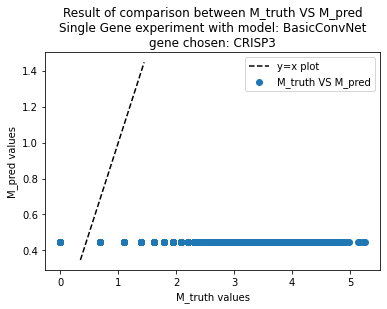

--delete-- x_boundry is 17612
--delete-- y_boundry is 15611
--delete-- values_matrix_true shape (17612, 15611)
Finished preparing values for plotting. now starting to plot, this might take a while ...


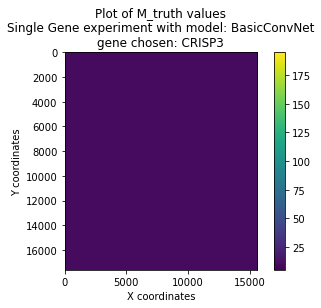

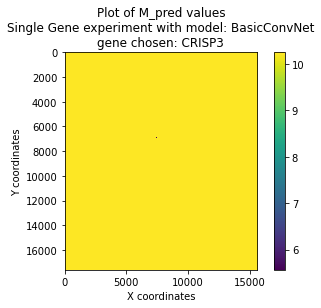

--delete--!!-- M_pred: [0.44669512 0.44669512 0.44669512 ... 0.44669512 0.44669512 0.44669512] 
----
M_truth: [0.         1.09861229 0.69314718 ... 0.         0.69314718 0.        ] 
       M_truth    M_pred
0     0.000000  0.446695
1     1.098612  0.446695
2     0.693147  0.446695
3     1.098612  0.446695
4     0.000000  0.446695
...        ...       ...
4010  1.386294  0.446695
4011  0.693147  0.446695
4012  0.000000  0.446695
4013  0.693147  0.446695
4014  0.000000  0.446695

[4015 rows x 2 columns]

----- finished function getSingleDimPrediction -----
distance between M_truth, M_pred: 82.4001487463042
distance between M_truth, Baseline: 72.28603324093415
distance between M_pred, Baseline: 39.55393674090626

----- finished function runExperiment -----
CPU times: user 19min 6s, sys: 6min 7s, total: 25min 14s
Wall time: 1h 3min 12s

finished experiment BasicConvNet

starting experiment **DensetNet121**


----- entered function runExperiment -----
/ * \ ENTERED train_prediction_model /

In [ ]:
experiment_loop(ds_train=custom_DS_SingleValuePerImg_augmented ,ds_test=custom_DS_SingleValuePerImg_test ,phase_name='single_gene_augmented')

## Phase 3: K genes prediction

In [ ]:
experiment_loop(ds_train=custom_DS_KGenesWithHighestVariance_augmented ,ds_test=custom_DS_KGenesWithHighestVariance_test ,phase_name='k_genes_augmented')

## Phase 4: All genes prediction - using dimensionality reduction techniques

### 4.1: Prediction using dimensionality reduction technique NMF

In [ ]:
experiment_loop(ds_train=custom_DS_LatentTensor_NMF_augmented ,ds_test=custom_DS_LatentTensor_NMF_test ,phase_name='NMF_augmented')

### 4.2: Prediction using dimensionality reduction technique AE

In [ ]:
experiment_loop(ds_train=custom_DS_LatentTensor_AE_augmented ,ds_test=custom_DS_LatentTensor_AE_test ,phase_name='AE_augmented')

<div class="alert alert-block alert-danger">
<b>Note:</b> below this - everything is a testing block
</div>

In [ ]:
import numpy as np
sampl = np.random.uniform(low=0.0, high=3.0, size=(1,))[0]
print(sampl)

In [ ]:
# ### create the value column in the dataframe  ###
# list_of_values_true = []
# list_of_values_pred = []
# x_list = []
# y_list = []
# dataset = custom_DS_SingleValuePerImg_augmented

# for index in range(dataset.num_of_images_with_no_augmentation):
#     # get file's name
#     if hasattr(dataset.imageFolder, 'samples'):  # meaning this is a regular "ImageFolder" type
#         curr_filename = dataset.imageFolder.samples[index][0]
#     else:  # meaning this is a custom DS I built - STDL_ConcatDataset_of_ImageFolders
#         _, curr_filename = dataset.imageFolder[index]

#     # get the sample's name from its absolute path and file name
#     curr_sample_name = curr_filename.partition('_')[0].partition('/images/')[2]  # first partition to get everything before the first _ , second partition to get everything after /images/

#     # get the y value's COLUMN in the gene expression matrix df (with help from the barcodes df)
#     index_in_barcoes_df = dataset.barcodes_dataframe.index[dataset.barcodes_dataframe['barcodes'] == curr_sample_name].item() # assumption: only 1 item is returned
#     column = dataset.column_mapping.index[dataset.column_mapping['original_index_from_matrix_dataframe'] == index_in_barcoes_df].item() # assumption: only one item is returned

#     # append the gene_exp value (pred or true) for that barcode
#     list_of_values_true.append(np.random.uniform(low=0.0, high=3.0, size=(1,))[0])
#     list_of_values_pred.append(np.random.uniform(low=0.0, high=3.0, size=(1,))[0])

#     # get the x and y values for that image name
#     x = curr_filename.partition('_')[2].partition('_')[0].partition('x')[2]
#     y = curr_filename.partition('_')[2].partition('_')[2].partition('_')[0].partition('y')[2]

#     # append x and y values. note the conversion - its because they are strings !
#     x_list.append(int(x))
#     y_list.append(int(y))  


# # # create a new dataframe with collectd data
# # df = pd.DataFrame({'x':x_list, 'y':y_list, 'gene_exp_level_true':list_of_values_true, 'gene_exp_level_pred':list_of_values_pred})
# # print(df)
# # print(f'and now print the plots')

# x_boundry = int(max(x_list)) + 1
# y_boundry = int(max(y_list)) + 1

# print(f'--delete-- x_boundry is {x_boundry}')
# print(f'--delete-- y_boundry is {y_boundry}')


# ## comented as test 300920 - the test is to make the colors in the plot more distinctive #TODO: delete later if not needed
# # orig
# # values_matrix_true = np.zeros([x_boundry,y_boundry]) # values is a 2d matrix - each entry is a color
# # values_matrix_pred = np.zeros([x_boundry,y_boundry]) # values is a 2d matrix - each entry is a color
# # new
# fill_value = np.max(list_of_values_true) + 10
# values_matrix_true = np.full(shape=[x_boundry,y_boundry], fill_value=fill_value) # values is a 2d matrix - each entry is a color
# values_matrix_pred = np.full(shape=[x_boundry,y_boundry], fill_value=fill_value) # values is a 2d matrix - each entry is a color
# ## end of test 300920

# print(f'x_list len {len(x_list)} max {max(x_list)} min {min(x_list)}')
# print(f'y_list len {len(y_list)} max {max(y_list)} min {min(y_list)}')



In [ ]:

# x_list = [x - min(x_list) for x in x_list]  # decreasing the size ...
# y_list = [x - min(y_list) for x in y_list]  # decreasing the size ...

# print(f'x_list len {len(x_list)} max {max(x_list)} min {min(x_list)}')
# print(f'y_list len {len(y_list)} max {max(y_list)} min {min(y_list)}')